# 자료 설명

* 칼럼 제거 : 4분위수, 미추정인구, 총인구수
* 이상치 제거 : IQR방식 (1.5) 이상치 제거


# 진행 사항

> 12월 4일  
> * 데이터 파악  
> * 데이터 전처리  
> * EDA 탐색적 데이터 분석
  
> 12월 5일  
> * 미추정 인구 칼럼 제거  
> * 4분위수 기준 이상치 제거  
> * 스케일링(Standard, MinMax, Robust)
  
> To Do  

> 분류 : 기본적으로 분류모델  
> 분류 : feature importance로 보며  
> 분류 : 파라미터 튜닝 중시  
> 회귀 : 시간 되면 로지스틱    
> 옵튜나 : 하이퍼 파라미터 GridSearchCV 모델보다 더 나은 것 같음  
> 데이터 전처리 - 분석 대상 선택(데이터, 칼럼) 부분 채우기
  
> 물어볼 것  
> * 이상치 제거 : 왜 연령대별로 묶는거?  
> * 이상치 제거 : 계속 진행하면 이상치 계속 나옴 -> 36,000대까지 데이터 수 떨어짐  
  
> 주제  
> * 1인가구의 배달 서비스 사용일수 예측  
> 넷플릭스 사용일수, 근무시간, 등등 배달 서비스 사용에 영향을 줄 만한 요소들을 가지고 예측

# 자료 불러오기 및 기본 전처리
  
<b>자료 변수</b>  
* 통신정보 월별 : data_tele_{월}  
* 통신정보 통합 : data_tele_ttl  
* 관심집단 월별 : data_concern_{월}  
* 관심집단 통합 : data_concern_ttl  
* 화재정보     : data_fire  
  
<b>임시 변수</b>  
* 통신정보 월별 -> 리스트 : data_tele_list  
* 관심집단 월별 -> 리스트 : data_concern_list  
  
<b>column 탐색 및 수정 결과</b>  
* 통신정보 7~9월 칼럼명 상이 : (행정동/행정동명), (총인구수/총인구) -> 1월에 맞춰 행정동, 총인구수로 통일    
* 통신정보 7~9월 데이터타입 상이 : '총인구수', '1인가구수' : (int/object) -> int로 통일  
* 관심집단 데이터는 이상 없음  

## 원천데이터 불러오기

In [6]:
# import
import pandas as pd
import openpyxl

# 파일 읽어와 DataFrame화 : 통신정보, 관심집단수
for i in range(1, 10):
    globals()[f'data_tele_{i}'] = pd.read_csv(f'data/2022.{i}월_29개 통신정보.csv', encoding='cp949')
    globals()[f'data_concern_{i}'] = pd.read_excel(f'data/2022.{i}월_10개 관심집단수.xlsx')

# 파일 읽어와 DataFrame화 : 화재정보
data_fire = pd.read_csv('data/소방청_화재발생 주소정보_20181231.csv', encoding='cp949')

# 자료 이름 설명
## * 통신정보 : data_tele_{월}  
## * 관심집단 : data_concern_{월}  
## * 화재정보 : data_fire

In [11]:
# 데이터 리스트 한 바구니에 담기
data_tele_list = [globals()[f'data_tele_{i}'] for i in range(1,10)]
data_concern_list = [globals()[f'data_concern_{i}'] for i in range(1,10)]



Index(['행정동코드', '자치구', '행정동', '성별', '연령대', '총인구수', '1인가구수',
       '야간상주지 변경 미추정 인구 수', '야간상주지 변경횟수 평균', '야간상주지 변경횟수: 4분위수, 25%',
       ...
       '배달_브랜드 서비스 사용 미추정 인구수', '배달_브랜드 서비스 사용일수',
       '배달_브랜드 서비스 사용일수: 4분위수, 25%', '배달_브랜드 서비스 사용일수: 4분위수, 50%',
       '배달_브랜드 서비스 사용일수: 4분위수, 75%', '배달_식재료 서비스 사용 미추정 인구수',
       '배달_식재료 서비스 사용일수', '배달_식재료 서비스 사용일수: 4분위수, 25%',
       '배달_식재료 서비스 사용일수: 4분위수, 50%', '배달_식재료 서비스 사용일수: 4분위수, 75%'],
      dtype='object', length=143)

In [28]:
import pandas as pd
import numpy as np

dt = []

for x in data_tele_1.columns:
    dt.append(data_tele_1[x].dtype)

df['칼럼명'] = pd.DataFrame(np.array(data_tele_1.columns))
df['칼럼 데이터타입'] = pd.DataFrame(np.array(dt))
df.to_csv('칼럼 리스트.csv', encoding='cp949')

## 원천데이터 column 탐색 및 통합

In [5]:
# column 일치 여부 탐색 함수

def exp_columns(data_list):
    for (i, j) in enumerate(data_list):
        count = 0
        print(f'== {i+1}월 데이터 ==')
        ## 칼럼 수 확인
        if len(data_list[0].columns) != len(j.columns):
            print('칼럼 수가 다릅니다.', f'1월 {len(data_list[0].columns)}개, {i+1}월 {len(j.columns)}개')
        # 칼럼 명, 데이터타입 확인
        for n, m in enumerate(j.columns):
            if data_list[0].columns[n] != m:
                print('칼럼 명이 다릅니다.', '1월 :', data_list[0].columns[n], ' / ', f'{i+1}월 : {m}')
                count += 1
            if data_list[0][data_list[0].columns[n]].dtype != j[m].dtype:
                print('데이터타입이 다릅니다.', '1월 : ',
                      f'{data_list[0].columns[n]} ',
                      f'{data_list[0][data_list[0].columns[n]].dtype} / ',
                      f'{i+1}월 : {m} {j[m].dtype}')
                count += 1
        ## 이상 없을 경우 "이상 없음" 메세지 출력
        if count == 0 : print("이상 없음")

    
# 관심집단 리스트 columns 탐색
print("*** 통신정보 데이터 ***")
exp_columns(data_tele_list), print("\n")
print("*** 관심집단 데이터 ***")
exp_columns(data_concern_list), print("\n")

*** 통신정보 데이터 ***
== 1월 데이터 ==
이상 없음
== 2월 데이터 ==
이상 없음
== 3월 데이터 ==
이상 없음
== 4월 데이터 ==
이상 없음
== 5월 데이터 ==
이상 없음
== 6월 데이터 ==
이상 없음
== 7월 데이터 ==
칼럼 명이 다릅니다. 1월 : 행정동  /  7월 : 행정동명
칼럼 명이 다릅니다. 1월 : 총인구수  /  7월 : 총인구
데이터타입이 다릅니다. 1월 :  총인구수  int64 /  7월 : 총인구 object
데이터타입이 다릅니다. 1월 :  1인가구수  int64 /  7월 : 1인가구수 object
== 8월 데이터 ==
칼럼 명이 다릅니다. 1월 : 행정동  /  8월 : 행정동명
칼럼 명이 다릅니다. 1월 : 총인구수  /  8월 : 총인구
데이터타입이 다릅니다. 1월 :  총인구수  int64 /  8월 : 총인구 object
데이터타입이 다릅니다. 1월 :  1인가구수  int64 /  8월 : 1인가구수 object
== 9월 데이터 ==
칼럼 명이 다릅니다. 1월 : 행정동  /  9월 : 행정동명
칼럼 명이 다릅니다. 1월 : 총인구수  /  9월 : 총인구
데이터타입이 다릅니다. 1월 :  총인구수  int64 /  9월 : 총인구 object
데이터타입이 다릅니다. 1월 :  1인가구수  int64 /  9월 : 1인가구수 object


*** 관심집단 데이터 ***
== 1월 데이터 ==
이상 없음
== 2월 데이터 ==
이상 없음
== 3월 데이터 ==
이상 없음
== 4월 데이터 ==
이상 없음
== 5월 데이터 ==
이상 없음
== 6월 데이터 ==
이상 없음
== 7월 데이터 ==
이상 없음
== 8월 데이터 ==
이상 없음
== 9월 데이터 ==
이상 없음




(None, None)

In [6]:
# 원천데이터 column 통합

# column 명 통합
for i in range(7, 10):
    globals()[f'data_tele_{i}'].columns = data_tele_1.columns
    
# column 데이터타입 통합
for i in range(7, 10):
    dt = globals()[f'data_tele_{i}']
    dt['총인구수'] = dt['총인구수'].str.replace(',','').astype('int64')
    dt['1인가구수'] = dt['1인가구수'].str.replace(',','').astype('int64')

In [7]:
# 관심집단 리스트 columns 재확인
print("*** 통신정보 데이터 ***")
exp_columns(data_tele_list), print("\n")
print("*** 관심집단 데이터 ***")
exp_columns(data_concern_list), print("\n")

*** 통신정보 데이터 ***
== 1월 데이터 ==
이상 없음
== 2월 데이터 ==
이상 없음
== 3월 데이터 ==
이상 없음
== 4월 데이터 ==
이상 없음
== 5월 데이터 ==
이상 없음
== 6월 데이터 ==
이상 없음
== 7월 데이터 ==
이상 없음
== 8월 데이터 ==
이상 없음
== 9월 데이터 ==
이상 없음


*** 관심집단 데이터 ***
== 1월 데이터 ==
이상 없음
== 2월 데이터 ==
이상 없음
== 3월 데이터 ==
이상 없음
== 4월 데이터 ==
이상 없음
== 5월 데이터 ==
이상 없음
== 6월 데이터 ==
이상 없음
== 7월 데이터 ==
이상 없음
== 8월 데이터 ==
이상 없음
== 9월 데이터 ==
이상 없음




(None, None)

## 원천데이터에 '월' 칼럼 만들기

In [8]:
for i in range(1, 10):
    data_tele_list[i-1]['월'] = int(i)
    data_concern_list[i-1]['월'] = int(i)

NameError: name 'data_tele_list' is not defined

## 원천데이터 하나로 통합

In [7]:
data_tele_ttl = pd.concat([x for x in data_tele_list])
data_concern_ttl = pd.concat([x for x in data_concern_list])

NameError: name 'data_tele_list' is not defined

## 불필요 칼럼 제거
* 4분위수,미추정인구,총인구수 등

In [11]:
for (i, j) in enumerate(data_tele_ttl.columns):
    if j.find('4분위수') != -1:
        data_tele_ttl.drop(columns=j, inplace=True)
    if j.find('미추정') != -1:
        data_tele_ttl.drop(columns=j, inplace=True)
    if j.find('행정동') != -1:
        data_tele_ttl.drop(columns=j, inplace=True)
    if j.find('자치구') != -1:
        data_tele_ttl.drop(columns=j, inplace=True)

## 통합파일 파일로 저장

In [12]:
data_tele_ttl.to_csv('data_tele_ttl.csv', index = False)
data_concern_ttl.to_csv('data_concern_ttl.csv', index = False)

# EDA 탐색적 데이터 분석
  
<b>null 값 탐색</b>  
* 통신정보 : null값 없음. 자치구명, 행정동명 외는 int, float형으로 분석 용이  
* 관심집단 : null값 없음. 자치구명, 행정동명 외는 int, float형으로 분석 용이  

<b>데이터 이상치 탐색</b>  
* IQR 방법 : 다수개의 이상치 데이터가 나왔으나, 생활패턴상 이상치가 충분히 나올 수 있다고 보여짐.  
* 자세한 내용은 하단 이상치 탐색 부분 참고 바라며,  
* 그럼에도 상세 데이터를 살펴 볼 필요 있음.  
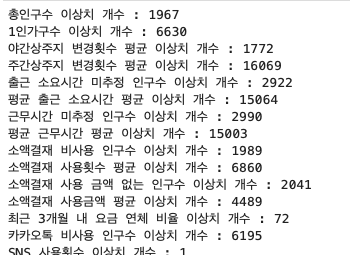  
  
<b>데이터 상관성 분석</b>  
* 연령대와 아래 칼럼들은 상관계수 abs 0.5 이상으로, 유의미한 상관성을 보임  
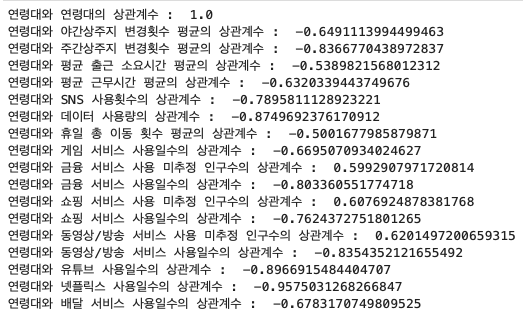  

## 통합파일 불러오기

In [4]:
import pandas as pd

data_tele_ttl = pd.read_csv('data_tele_ttl.csv')
data_concern_ttl = pd.read_csv('data_concern_ttl.csv')

## 데이터 Info, Describe

In [11]:
print(data_tele_ttl.info())
print(data_concern_ttl.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91584 entries, 0 to 91583
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   행정동코드              91584 non-null  int64  
 1   자치구                91584 non-null  object 
 2   행정동                91584 non-null  object 
 3   성별                 91584 non-null  int64  
 4   연령대                91584 non-null  int64  
 5   총인구수               91584 non-null  int64  
 6   1인가구수              91584 non-null  int64  
 7   야간상주지 변경횟수 평균      91584 non-null  float64
 8   주간상주지 변경횟수 평균      91584 non-null  float64
 9   평균 출근 소요시간 평균      91584 non-null  float64
 10  평균 근무시간 평균         91584 non-null  float64
 11  소액결재 비사용 인구수       91584 non-null  int64  
 12  소액결재 사용횟수 평균       91584 non-null  float64
 13  소액결재 사용 금액 없는 인구수  91584 non-null  int64  
 14  소액결재 사용금액 평균       91584 non-null  float64
 15  최근 3개월 내 요금 연체 비율  91584 non-null  float64
 16  카카오톡 비사용 인구수       915

In [36]:
print(data_tele_ttl.describe())
print(data_concern_ttl.describe())

              행정동코드            성별           연령대          총인구수         1인가구수  \
count  9.158400e+04  91584.000000  91584.000000  91584.000000  91584.000000   
mean   1.113664e+06      1.500000     47.500000    806.456674    151.575341   
std    7.402783e+03      0.500003     17.260357    425.916910    172.004528   
min    1.101053e+06      1.000000     20.000000     17.000000      2.000000   
25%    1.107070e+06      1.000000     33.750000    494.000000     66.000000   
50%    1.114068e+06      1.500000     47.500000    750.000000    107.000000   
75%    1.120318e+06      2.000000     61.250000   1039.000000    174.000000   
max    1.125074e+06      2.000000     75.000000   4978.000000   3003.000000   

       야간상주지 변경 미추정 인구 수  야간상주지 변경횟수 평균  주간상주지 변경 미추정 인구수  주간상주지 변경횟수 평균  \
count            91584.0   91584.000000           91584.0   91584.000000   
mean                 0.0       1.741244               0.0       2.450123   
std                  0.0       0.296786               0.0   

## 데이터 상관계수 corr

In [3]:
# 연령과 타 칼럼 상관계수 구하기 함수 정의
def corr_of_age_and_other(df, target='연령대', percent=50):
    '''
    데이터프레임의 연령대 칼럼과 각 칼럼 간 상관계수를 출력합니다.
    percent : 상관계수가 x%이상인 칼럼간 상관계수만 출력합니다.
    '''
    for i in df.columns:
        if df[i].dtype == 'object':
            continue
        else:
            try:
                if df[target].corr(df[i]) > percent/100 or df[target].corr(df[i]) < (-1)*percent/100:
                    print(f'{target}과/와 {i}의 상관계수 : ', df[target].corr(df[i]))
            except:
                continue

In [4]:
# 함수 실행
corr_of_age_and_other(data_tele_ttl, '1인가구수', 50)

1인가구수과/와 1인가구수의 상관계수 :  1.0
1인가구수과/와 소액결재 비사용 인구수의 상관계수 :  0.5310116805533346
1인가구수과/와 소액결재 사용 금액 없는 인구수의 상관계수 :  0.511961817325725


In [2]:
# 전체 칼럼 상관계수 구하기 함수 정의
def corr_of_two_columns(df, percent, age=[20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]):
    '''
    데이터프레임의 각 칼럼 간 상관계수를 출력합니다.
    percent : 상관계수가 x%이상인 칼럼간 상관계수만 출력합니다.
    age : 대상 연령대를 선택합니다. 선택하지 않으면 모든 연령대가 선택됩니다.
    '''
    if age == [20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70]:
        pass
    else:
        df = df.loc[df['연령대'] == age]
    
    for i in df.columns:
        print(f'■■■ {i} 관련 상관계수 ■■■')
        for j in df.columns:
            if df[i].dtype == 'object' or df[j].dtype == 'object':
                continue
            else:
                try:
                    if df[i].corr(df[j]) > percent/100 or df[i].corr(df[j]) < (-1)*percent/100:
                        print(f'{i}와 {j}의 상관계수 : ', df[i].corr(df[j]))
                except:
                    continue

In [5]:
# 함수 실행
## 연령대 선택
age = 20
## 상관계수 산출 함수 실행
corr_of_two_columns(data_tele_ttl, 40)

■■■ 성별 관련 상관계수 ■■■
성별와 성별의 상관계수 :  0.9999999999999998
성별와 평균 통화대상자 수의 상관계수 :  -0.4643202629318013
성별와 평일 총 이동 거리 합계의 상관계수 :  -0.6051422679487533
성별와 게임 서비스 사용일수의 상관계수 :  -0.5574406641424641
■■■ 연령대 관련 상관계수 ■■■
연령대와 연령대의 상관계수 :  1.0
연령대와 야간상주지 변경횟수 평균의 상관계수 :  -0.6491113994499464
연령대와 주간상주지 변경횟수 평균의 상관계수 :  -0.8366770438972835
연령대와 평균 출근 소요시간 평균의 상관계수 :  -0.538982156801231
연령대와 평균 근무시간 평균의 상관계수 :  -0.632033944374968
연령대와 카카오톡 비사용 인구수의 상관계수 :  0.4558326342510188
연령대와 SNS 사용횟수의 상관계수 :  -0.7895811128923226
연령대와 평균 통화량의 상관계수 :  -0.4393773038883442
연령대와 데이터 사용량의 상관계수 :  -0.8749692376170912
연령대와 평일 총 이동 횟수의 상관계수 :  -0.45393007181714795
연령대와 휴일 총 이동 횟수 평균의 상관계수 :  -0.5001677985879871
연령대와 집 추정 위치 평일 총 체류시간의 상관계수 :  0.4712974043219991
연령대와 집 추정 위치 휴일 총 체류시간의 상관계수 :  0.42605727528562753
연령대와 휴일 총 이동 거리 합계의 상관계수 :  -0.41944184386373423
연령대와 지하철이동일수 합계의 상관계수 :  -0.4880320113915491
연령대와 게임 서비스 사용일수의 상관계수 :  -0.6695070934024627
연령대와 금융 서비스 사용일수의 상관계수 :  -0.803360551774718
연령대와 쇼핑 서비스 사용일수의 상관계수 :  -

# 데이터 전처리

## 이상치 제거 : 4분위수 기준  
https://jimmy-ai.tistory.com/260

In [90]:
# BOXPLOT 사용한 이상치 탐색
import matplotlib as mlt
import matplotlib.pyplot as plt

colname = data_tele_ttl.columns[int(input('칼럼 번호를 입력해주세요'))+1]
print(f'칼럼명 : {colname}')

fig, ax = plt.subplots()
ax.boxplot(data_tele_ttl[colname])
ax.get_xlabel = colname
plt.show()

칼럼 번호를 입력해주세요 ffff


ValueError: invalid literal for int() with base 10: 'ffff'

In [83]:
# IQR 방식 적용한 이상치 탐색
# 반환값 : 이상치 인덱스

def outlier_iqr_exp(df, weight=1.5, columns=None):
    '''
    함수 설명
    * IQR 기법을 통한 이상치 탐색
    * 이상치 값이 있는 인덱스를 반환합니다.
    
    파라미터 설명
    * df : 이상치를 탐색할 데이터프레임
    * weight : float, default:1.5
    '''
    
    outlier_index_set = set()
    
    for i in columns:
        try:
            if df[i].dtype == 'object':
                continue
            else:
                q3 = df[i].quantile(0.75)
                q1 = df[i].quantile(0.25)
                iqr = q3 - q1
                outlier_q1_under = df[i][df[i] < q1 - (weight * iqr)]
                outlier_q3_over = df[i][df[i] > q3 + (weight * iqr)]
                count = int(outlier_q1_under.count()) + int(outlier_q3_over.count())
                if count > 0:
                    print(f'{i} 이상치 개수 : {count}')
                    outlier_index_set = outlier_index_set.union(set(outlier_q1_under.index))
                    outlier_index_set = outlier_index_set.union(set(outlier_q3_over.index))
        except:
            continue
        
    return list(outlier_index_set)

In [85]:
# IQR 방식의 이상치 제거 방식
def outlier_iqr_remove(df, weight=1.5, columns=None):
    outlier_index_list = outlier_iqr_exp(df, 0, columns=None)
    print(f'== 제거 전 index 수 : {df[df.columns[0]].count()} ==')
    df2 = df.drop(outlier_index_list)
    print(f'== 제거된 index 수 : {len(outlier_index_list)} ==')
    print(f'== 제거 후 index 수 : {df2[df2.columns[0]].count()} ==')
    return df2

In [86]:
# IQR 방식의 이상치 제거 진행, 인덱스 초기화
## 근데.. 계속 진행하면 계속 이상치가 나오는데?
columns = ['데이터 사용량']
data_tele_iqred = outlier_iqr_remove(data_tele_ttl, 0, columns)
data_tele_iqred.reset_index(drop=True, inplace=True)
data_tele_iqred

TypeError: 'NoneType' object is not iterable

In [2]:
# IQR 방식 이상치 제거 (기현)
# 백분위 75%  ~백분위 25% 만 (weight로 조절 가능)
def get_outlier(df=None, column=None, weight=1.5):
    import numpy as np
    age_group_list = [20,30,40,50,60,70]
    outlier_index_set = set()
    
    # 인덱스 리셋
    data_tele_ttl.reset_index(drop=True, inplace=True)
    
    for age_group in age_group_list:
        # fraud에 해당하는 column 데이터만 추출, 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
        fraud = df[df['연령대']==age_group][column]
        quantile_25 = np.percentile(fraud.values, 25)
        quantile_75 = np.percentile(fraud.values, 75)
        iqr = quantile_75 - quantile_25
        iqr_weight = iqr * weight
        lowest_val = quantile_25 - iqr_weight
        highest_val = quantile_75 + iqr_weight
        # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 DataFrame index 반환. 
        outlier_index_set = outlier_index_set | set(fraud[(fraud < lowest_val) | (fraud > highest_val)].index)
        
    return outlier_index_set

def remove_outlier(df_in=None,column_list=None, weight=1.5):
    outlier_index_set = set()
    df = df_in.copy() # 원본데이터 보존
    print(f'== 제거 전 index 수 : {df[df.columns[0]].count()} ==')
    for column_name in column_list:
        outlier_index = get_outlier(df=df, column=column_name, weight=weight)
        outlier_index_set = outlier_index_set | outlier_index
        print(f'== 제거된 index 수 : {len(list(outlier_index))} ==')
        
    df.drop(list(outlier_index_set), inplace=True)
    print(f'== 제거 후 index 수 : {df[df.columns[0]].count()} ==')
    
    data_tele_iqred = df
    
    return data_tele_iqred

list_col = list(data_tele_ttl.columns).copy()
data_tele_iqred = remove_outlier(data_tele_ttl, ['데이터 사용량'], 0.0)
print(f'이상치 제거 전 : {data_tele_ttl["연령대"].count()}, 이상치 제거 후 : {data_tele_iqred["연령대"].count()}')

== 제거 전 index 수 : 91584 ==
== 제거된 index 수 : 21369 ==
== 제거 후 index 수 : 70215 ==
이상치 제거 전 : 91584, 이상치 제거 후 : 70215


In [98]:
data_tele_ttl.columns

Index(['성별', '연령대', '1인가구수', '야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균',
       '평균 근무시간 평균', '소액결재 비사용 인구수', '소액결재 사용횟수 평균', '소액결재 사용 금액 없는 인구수',
       '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율', '카카오톡 비사용 인구수', 'SNS 사용횟수',
       '평균 통화량', '평균 문자량', '평균 통화대상자 수', '평균 문자대상자 수', '데이터 사용량', '평일 총 이동 횟수',
       '휴일 총 이동 횟수 평균', '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간',
       '평일 총 이동 거리 합계', '휴일 총 이동 거리 합계', '지하철이동일수 합계', '게임 서비스 사용일수',
       '금융 서비스 사용일수', '쇼핑 서비스 사용일수', '동영상/방송 서비스 사용일수', '유튜브 사용일수',
       '넷플릭스 사용일수', '배달 서비스 사용일수', '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수', '월'],
      dtype='object')

In [95]:
data_tele_ttel.columns

NameError: name 'data_tele_ttel' is not defined

## 데이터 인코딩

In [8]:
# 원 핫 인코더  
  
def one_hot_encoder(target):
    from sklearn.preprocessing import OneHotEncoder
    import numpy as np
    '''target:범주형 칼럼 등'''
    target_v_list = target.to_list()
    target_ohe = OneHotEncoder().fit_transform(np.array(target).reshape(-1, 1)).toarray().astype(int)
    target_ohe = pd.DataFrame(target_ohe).rename(columns = {'title' : target_v_list})
    
    return target_ohe

In [9]:
# 라벨 인코더

def label_encoder(target):
    from sklearn.preprocessing import LabelEncoder
    import numpy as np
    import pandas as pd
    '''target:범주형 칼럼 등'''
    target = pd.DataFrame(LabelEncoder().fit_transform(target))
    
    return target

In [ ]:
# # 레이블 인코딩

# from sklearn.preprocessing import LabelEncoder
# encoder = LabelEncoder()

# for i in data_tele_iqred[['행정동'], ['자치구']]:
#     encoder.fit_transform
    

## 분석 대상 선택(데이터, 칼럼)

## 데이터셋 분리 (훈련, 테스트)

In [4]:
def train_test_sp(dataset, target='연령대'):
    '''
    * dataset : 분리할 데이터셋을 입력합니다.
    세 가지 스케일링을 함을 고려해, 향후 for (i, j) in enumerate(scaled_df_list) 후 반환값은 i_X 식으로 받음
    
    * target : target 칼럼명. 기본값은 연령대.
    '''
    from sklearn.model_selection import train_test_split
    
    X = dataset.copy().drop(columns=target, axis=1)
    y = dataset[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    return X_train, X_test, y_train, y_test

## 스케일링
  
* Standard Scaling : 평균이 0이고 분산이 1인 값으로 변환, SVM, LinearR, LogisticR에 중요  
* MinMax Scaling : 데이터값을 0과 1 사이의 범위 값으로 변환 (음수는 -1 ~ 1)  
* Robust Scaling : 평균과 분산 대신에 중앙값(median)과 IQR(interquartile range) 사용해 아웃라이어의 영향을 최소화  

In [7]:
import pandas as pd

In [5]:
# Standard Scaling
def standard_scaling(df):
    from sklearn.preprocessing import StandardScaler
    import pandas as pd
    
    scaler = StandardScaler()    
    drop_column_list = []
    
    for i in df.columns:
        if df[i].dtype == 'object':
            drop_column_list.append(i)
    
    df_object = df[drop_column_list]
    df_not_object = df.drop(columns = drop_column_list)
    columns = df_not_object.columns
    
    df_not_object = pd.DataFrame(scaler.fit_transform(df_not_object), columns=columns)
    df_not_object.reset_index(drop=True, inplace=True)
    df_object.reset_index(drop=True, inplace=True)
    df_stand_scaled = pd.concat([df_object, df_not_object], axis=1)
    
    return df_stand_scaled

In [6]:
# MinMax Scaling
def minmax_scaling(df):
    from sklearn.preprocessing import MinMaxScaler
    import pandas as pd
    
    scaler = MinMaxScaler()
    drop_column_list = []
    
    for i in df.columns:
        if df[i].dtype == 'object':
            drop_column_list.append(i)
            
    df_object = df[drop_column_list]
    df_not_object = df.drop(columns = drop_column_list)
    columns = df_not_object.columns
    
    df_not_object = pd.DataFrame(scaler.fit_transform(df_not_object), columns=columns)
    df_not_object.reset_index(drop=True, inplace=True)
    df_object.reset_index(drop=True, inplace=True)
    df_minmax_scaled = pd.concat([df_object, df_not_object], axis=1)     
    
    return df_minmax_scaled

In [7]:
# Robust Scaling
def robust_scaling(df):
    from sklearn.preprocessing import RobustScaler
    import pandas as pd
    
    scaler = RobustScaler()
    drop_column_list = []
    
    for i in df.columns:
        if df[i].dtype == 'object':
            drop_column_list.append(i)
            
    df_object = df[drop_column_list]
    df_not_object = df.drop(columns = drop_column_list)
    columns = df_not_object.columns
    
    df_not_object = pd.DataFrame(scaler.fit_transform(df_not_object), columns=columns)
    df_not_object.reset_index(drop=True, inplace=True)
    df_object.reset_index(drop=True, inplace=True)
    df_robust_scaled = pd.concat([df_object, df_not_object], axis=1)     
    
    return df_robust_scaled

In [49]:
# Standard Scaling

# def standard_scaling(X_train, X_test):
#     from sklearn.preprocessing import StandardScaler
#     import pandas as pd
    
#     scaler = StandardScaler()    
    
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     return X_train, X_test

In [50]:
# MinMax Scaling

# def minmax_scaling(X_train, X_test):
#     from sklearn.preprocessing import MinMaxScaler
#     import pandas as pd
    
#     scaler = MinMaxScaler()
    
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     return X_train, X_test

In [51]:
# Robust Scaling

# def robust_scaling(X_train, X_test):
#     from sklearn.preprocessing import RobustScaler
#     import pandas as pd
    
#     scaler = RobustScaler()
    
#     X_train = scaler.fit_transform(X_train)
#     X_test = scaler.transform(X_test)
    
#     return X_train, X_test

# 머신러닝 - 분류  
    
><b> 상관성</b>  
>연령대와 <u><b>상관성 높은 feature들은 다수</b></u> 있으며, 그 종류는 아래와 같음  
>피어슨 상관계수 (-1 ~ 1)  
>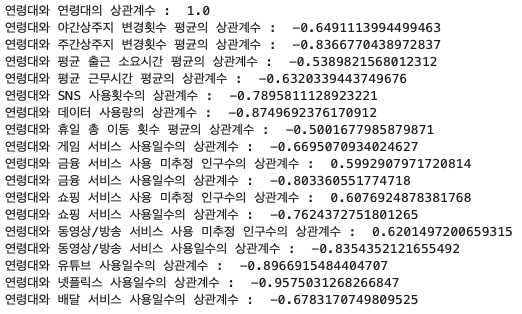  


<b>머신러닝 예정</b>  
> 개요  
> * 분류와 회귀 모델 모두 적용 가능한 모델로 보이며
> * <u><b>상관성 높은 feature들이 많아, 유의미한 분석 모델</b></u>이 나올 것으로 예상된다.  
> * 단, 독립변수가 많고, 변수간 상관성이 높은 경우가 있어, 다중공선성 방지를 위해 주성분 분석이 필요함.  
> * (참고) 종속변수인 연령대가 범주형 변수이긴 하나, 임의로 연속형 변수로 보고 예상 나이를 추출하는 회귀 가능  

## 평가 모델 생성

In [3]:
def evaluate(target, pred, pred_proba):
    
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import f1_score
    from sklearn.metrics import roc_auc_score
    
    print(f'정확도 : {accuracy_score(target, pred):.2f} \n',
          f'정밀도 : {precision_score(target, pred, average="micro"):.2f} \n',
          f'재현율 : {recall_score(target, pred, average="micro"):.2f} \n',
          f'f1 score : {f1_score(target, pred, average="micro"):.2f} \n')
    try:
        print(f'AUC score : {roc_auc_score(target, pred, pred_broba, average="micro", multi_class="ovo"):.2f} \n')
    except:
        print('AUC score 출력 실패')

## 결정 트리

In [133]:
# 평가 모델 함수
def dtc(X_train, X_test, y_train, y_test):
    from sklearn.tree import DecisionTreeClassifier
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')
    
    print('진행1/2.. 학습중')
    # 모델 학습
    dtc = DecisionTreeClassifier(max_depth=8, min_samples_split=100, min_samples_leaf=50)
    dtc.fit(X_train, y_train)
    feature_impt = dtc.fit(X_train, y_train).feature_importances_
    
    print('진행2/2.. 예측중')
    # 예측
    pred = dtc.predict(X_test)
    pred_proba = dtc.predict_proba(X_test)
    
    print('진행 완료')
    
    return pred, y_test, pred_proba, feature_impt

In [134]:
# 결정 트리 진행 및 평가

# 분석 대상 칼럼 결정
columns = ['연령대', '데이터 사용량', '평균 출근 소요시간 평균', '유튜브 사용일수', '넷플릭스 사용일수', '쇼핑 서비스 사용일수',
           '평균 문자대상자 수', '평일 총 이동 거리 합계', '평균 통화대상자 수', '금융 서비스 사용일수', '평균 문자량']

## 훈련 - 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_sp(data_tele_iqred[columns])

## 스케일링
X_train = standard_scaling(X_train)
X_test = standard_scaling(X_test) 

## 원 핫 인코딩
y_train = one_hot_encoder(y_train)
y_test = one_hot_encoder(y_test)

## 파라미터
param = {
    'max_depth' : 8,
    'min_samples_split' : 100,
    'min_samples_leaf' : 50
}

## 학습 및 예측
pred, y_test, pred_proba, feature_impt = dtc(X_train, X_test, y_train, y_test)

## 평가
evaluate(y_test, pred, pred_proba)
feature_impt


진행1/2.. 학습중
진행2/2.. 예측중
진행 완료
정확도 : 0.87 
 정밀도 : 0.88 
 재현율 : 0.87 
 f1 score : 0.88 

AUC score 출력 실패


array([0.11551375, 0.07692783, 0.14079259, 0.22686615, 0.08870706,
       0.12067691, 0.0245326 , 0.04351552, 0.15861527, 0.0038523 ])

In [64]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(param)

dtc.fit(X_train, y_train)     # 학습 시키기
dtc_pred = dtc.predict(X_test)

from sklearn.tree import export_graphviz

export_graphviz(dtc, out_file='dct.dot',
                class_names = ['20', '25', '30', '35', '40', '45', '50', '55', '60', '65', '70'],
                feature_names = columns.remove('연령대'))
                
import graphviz


with open('dct.dot', encoding='utf-8') as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

TypeError: __init__() takes 1 positional argument but 2 were given

In [1]:
from sklearn.tree import DecisionTreeClassifier

DecisionTreeClassifier().predict_proba()

## 랜덤 포레스트

In [ ]:
def rf_clf(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestClassifier
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')
    
    print('진행1/2.. 학습중')
    # 모델 학습
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    print('진행2/2.. 예측중')
    
    # 예측
    pred = rf_clf.predict(X_test)
    pred_proba = rf_clf.predict_proba(X_test)
    print('진행 완료')
    
    # feature importrance
    feature_impt = rf_clf.fit().feature_importances_
    
    return pred, y_test, pred_proba, feature_impt

In [ ]:
# 랜덤포레스트 진행 및 평가

## 훈련 - 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_sp(data_tele_iqred)

## 스케일링
X_train = standard_scaling(X_train)
X_test = standard_scaling(X_test)

## 원 핫 인코딩
y_train = one_hot_encoder(y_train)
y_test = one_hot_encoder(y_test)

## 학습 및 예측
pred, y_test, pred_proba, feture_impta= rf_clf(X_train, X_test, y_train, y_test)

## 평가
evaluate(y_test, pred)
feature_impt

## GBM

In [48]:
def gbm(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import GradientBoostingClassifier
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')
    
    print('진행1/2.. 학습중')
    # 모델 학습
    gbm = GradientBoostingClassifier()
    gbm.fit(X_train, y_train)
    print('진행2/2.. 예측중')
    
    # 예측
    pred = gbm.predict(X_test)
    print('진행 완료')
    
    return pred, y_test

In [55]:
# GBM 진행 및 평가

## 훈련 - 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_sp(data_tele_iqred)

## 스케일링
X_train = standard_scaling(X_train)
X_test = standard_scaling(X_test)

## 원 핫 인코딩
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)

## 학습 및 예측
pred, y_test = gbm(X_train, X_test, y_train, y_test)

## 평가
evaluate(y_test, pred)

진행1/2.. 학습중
진행2/2.. 예측중
진행 완료
정확도 : 0.97 
 정밀도 : 0.97 
 재현율 : 0.97 
 f1 score : 0.97 



## XGBoost

In [92]:
def xgb(X_train, X_test, y_train, y_test):
    import XGBoost 
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')
    
    print('진행1/2.. 학습중')
    # 모델 학습
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train, early_stopping_round=50)
    print('진행2/2.. 예측중')
    
    # 예측
    pred = xgb.predict(X_test)
    print('진행 완료')
    
    return pred, y_test

In [93]:
# XGBoost 진행 및 평가

## 훈련 - 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_sp(data_tele_iqred)

## 스케일링
X_train = standard_scaling(X_train)
X_test = standard_scaling(X_test)

## 원 핫 인코딩
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)

## 학습 및 예측
pred, y_test = xgb(X_train, X_test, y_train, y_test)

## 평가
evaluate(y_test, pred)

ModuleNotFoundError: No module named 'XGBoost'

## LightGBM

In [58]:
def xgb(X_train, X_test, y_train, y_test):
    from lightgbm import LGBMClassifier
    import pandas as pd
    import warnings
    warnings.filterwarnings('ignore')
    
    print('진행1/2.. 학습중')
    # 모델 학습
    lgbm = LGBMClassifier()
    lgbm.fit(X_train, y_train)
    print('진행2/2.. 예측중')
    
    # 예측
    pred = lgbm.predict(X_test)
    print('진행 완료')
    
    return pred, y_test

In [ ]:
# LightGBM 진행 및 평가

## 훈련 - 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_sp(data_tele_iqred)

## 스케일링
X_train = standard_scaling(X_train)
X_test = standard_scaling(X_test)

## 원 핫 인코딩
y_train = label_encoder(y_train)
y_test = label_encoder(y_test)

## 학습 및 예측
pred, y_test = lgbm(X_train, X_test, y_train, y_test)

## 평가
evaluate(y_test, pred)

# 머신러닝 - 회귀

## 평가 모델

In [ ]:
def evaluation_reg(pred, y_test):
    from sklearn.metrics import mean_absolute_error
    mse = mean_absolute_error(y_tert,y_pred)
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(y_test, y_pred)
    import numpy as np
    rmse = np.sqrt(MSE)
    from sklearn.metrics import r2_score
    r2 = r2_score(y, lr.predict(x_2))
    
    print(f'mse
    

## 의사결정나무 회귀

In [8]:
def dtr(X_train, X_test, y_train, y_test, param=None):

    from sklearn.tree import DecisionTreeRegressor

    md = param.get('max_depth')
    mss = param.get('min_samples_split') 
    msl = param.get('min_samples_leaf')
    
    print('1/2.. 모델링')
    dtr = DecisionTreeRegressor(max_depth=md, min_samples_split = mss, min_samples_leaf = msl)
    
    print('2/2.. 학습중')

    dtr.fit(X_train, y_train)
    pred = dtr.predict(X_test)
    print('진행 완료')

    return pred, y_test



In [10]:
# 모델 진행
all_feature = ['성별', '연령대', '1인가구수', '야간상주지 변경횟수 평균', '주간상주지 변경횟수 평균', '평균 출근 소요시간 평균',
               '평균 근무시간 평균', '소액결재 비사용 인구수', '소액결재 사용횟수 평균', '소액결재 사용 금액 없는 인구수',
               '소액결재 사용금액 평균', '최근 3개월 내 요금 연체 비율', '카카오톡 비사용 인구수', 'SNS 사용횟수',
               '평균 통화량', '평균 문자량', '평균 통화대상자 수', '평균 문자대상자 수', '데이터 사용량', '평일 총 이동 횟수',
               '휴일 총 이동 횟수 평균', '집 추정 위치 평일 총 체류시간', '집 추정 위치 휴일 총 체류시간',
               '평일 총 이동 거리 합계', '휴일 총 이동 거리 합계', '지하철이동일수 합계', '게임 서비스 사용일수',
               '금융 서비스 사용일수', '쇼핑 서비스 사용일수', '동영상/방송 서비스 사용일수', '유튜브 사용일수',
               '넷플릭스 사용일수', '배달 서비스 사용일수', '배달_브랜드 서비스 사용일수', '배달_식재료 서비스 사용일수', '월']

## 데이터 칼럼 선택
feature = ['배달 서비스 사용일수', '평균 근무시간 평균', '평균 출근 소요시간 평균'] # 사용할 변수명
target = '배달 서비스 사용일수' # 타겟 변수명

data = data_tele_iqred[feature]
X_train, X_test, y_train, y_test = train_test_sp(data, target)


## 파라미터
param = {
    'max_depth' : 200,
    'min_samples_split' : 40,
    'min_samples_leaf' : 40
}

## 학습 및 예측
pred, y_test = dtr(X_train, X_test, y_train, y_test, param)

## 평가
from sklearn.tree import DecisionTreeRegressor
dtrr = DecisionTreeRegressor(max_depth = param.get('max_depth'),
                   min_samples_split = param.get('min_samples_split'),
                   min_samples_leaf = param.get('min_samples_leaf'))
model = dtrr.fit(X_train, y_train)


from sklearn.metrics import r2_score
r2 = r2_score(pred, y_test)
r2

1/2.. 모델링
2/2.. 학습중
진행 완료


-1.7836681361036377

In [ ]:
from sklearn.tree import DecisionTreeRegressor


In [ ]:
from sklearn.linear_model import LinearRegression

## 랜덤포레스트 회귀

In [128]:
def rfr(X_train, X_test, y_train, y_test, param):

    from sklearn.ensemble import RandomForestRegressor

    md = param.get('max_depth')
    mss = param.get('min_samples_split') 
    msl = param.get('min_samples_leaf')
    
    print('1/2.. 모델링')
    rfr = RandomForestRegressor(max_depth=md, min_samples_split = mss, min_samples_leaf = msl)
    
    print('2/2.. 학습중')

    rfr.fit(X_train, y_train)
    pred = rfr.predict(X_test)
    print('진행 완료')

    return pred, y_test



In [129]:
# 모델 진행

## 훈련 - 테스트 데이터 나누기
X_train, X_test, y_train, y_test = train_test_sp(data_tele_iqred)

## 파라미터
param = {
    'max_depth' : 200,
    'min_samples_split' : 20,
    'min_samples_leaf' : 40
}

## 학습 및 예측
# pred, y_test = rfr(X_train, X_test, y_train, y_test)

## 평가
from sklearn.ensemble import RandomForestRegressor
rfrr = RandomForestRegressor(max_depth = param.get('max_depth'),
                   min_samples_split = param.get('min_samples_split'),
                   min_samples_leaf = param.get('min_samples_leaf'))
model = rfrr.fit(X_train, y_train)


KeyboardInterrupt: 

## 로지스틱 회귀 

## 다항회귀

## 주성분 분석

In [71]:
from sklearn.decomposition import PCA

pca = PCA()